In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

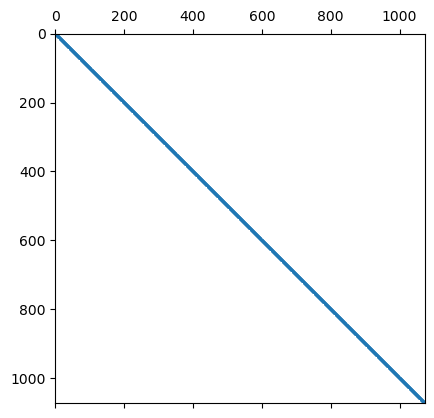

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/pores_1/"
# path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)
assert np.all(A.toarray() == A.toarray().T)
np.linalg.cond(A.toarray())

In [3]:
N = A.shape[0]
# b = np.ones((N))
b = np.random.uniform(size=N)
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


7.012060430444545e-16

In [4]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[ 2.77555756e-17 -6.66133815e-16  2.22044605e-16 ...  8.88178420e-16
  0.00000000e+00 -1.11022302e-15]


In [5]:
np.linalg.cond(A.toarray())

8266217.206972408

In [6]:
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d

def krylov(M, A, r):
    M[0] = r.copy()
    for i in range(1, len(M)):
        M[i] = A @ M[i-1]
    return M, M @ r


In [15]:
numsteps = 3
Rs = np.zeros([numsteps, N])
alphas = np.zeros(numsteps)
betas = np.zeros(numsteps)
Ps = np.zeros([numsteps, N])
Xs = np.zeros([numsteps, N])
def cg_algo23(A, b, numsteps):
    x = np.zeros(b.shape)
    r = b - A @ x
    p = r
    Ar = A @ r
    rr = r @ r
    rAr = r @ Ar
    alpha = rr / rAr
    beta = 0.0
    Ap = np.ones(*r.shape)
    print("      r         alpha          beta             p           x")
    for i in range(numsteps):
        p = r + beta * p
        Ap = Ar + beta * Ap
        rcheck = np.all(np.isclose(b - A @ x, r))
        x += alpha * p
        print(f"{np.linalg.norm(r):7.5}, "
              f"{alpha:12.5}, "
              f"{beta:12.5}, "
              f"{np.linalg.norm(p):12.5}"
              f"{np.linalg.norm(x):12.5}"
              f" {rcheck}"
             )
        Rs[i], alphas[i], betas[i], Ps[i], Xs[i] = r, alpha, beta, p, x
        r = r - alpha * Ap
        Ar = A @ r
        rAr = r @ Ar
        beta = r @ r / rr
        rr = r @ r
        alpha = rr / (rAr - beta/alpha * rr)
    return x

x_sol_23 = cg_algo23(A, b, numsteps)
r = A @ x_sol_23 - b
# print(np.linalg.norm(r))
# assert np.all(np.isclose(r, 0)), "Not a solution."

      r         alpha          beta             p           x
 19.049,   0.00026432,          0.0,       19.049    0.005035 True
 267.35,   3.6176e-06,       196.97,       3761.6    0.018634 True
 209.49,   1.3875e-06,      0.61402,       2319.2     0.02184 True


In [41]:
s = 1
x = np.zeros(b.shape)
P = np.zeros([s, len(b)])
Q = np.zeros([s, len(b)])
mu = np.zeros(2*s)
beta = np.zeros([s, s])
#alpha = np.zeros(s)
c = np.ones([s, s])

r = b - A @ x
# print(np.linalg.norm(r))
residuals = [r]
Q, mu = krylov(Q, A, r)

print("      r         alpha          beta             p           x")
for i in range(numsteps):
    if i > 0:
        Akr = r.copy()
        c[0, -1] = - r @ Akr / alpha[-1]
        beta[0] = np.linalg.solve(W, -c[0])
        for k in range(1, s):
            Akr = A @ Akr
            c[k, :-1] = c[k, 1:]
            rest = sum([alpha[-2-t] * c[k, -2-t] for t in range(k)])
            # assert np.isclose(r @ Akr, mu[k])
            c[k, -1] = -1 / alpha[-1] * ((r @ Akr) + rest)
            beta[k] = np.linalg.solve(W, -c[k])
    W = np.array([[pj @ A @ pi for pi in Q] for pj in Q])    
    mod = - beta/alpha * mu if i > 0 else 0
    alpha = np.linalg.solve(W + mod, mu)
    Q = Q + beta @ P
    x = x + alpha @ Q
    # check(x, b)
    print(f">> {np.linalg.norm(r - Rs[i]):12.5}, "
          f"{np.linalg.norm(alpha - alphas[i]):12.5}, "
          f"{np.linalg.norm(beta - betas[i]):12.5}, "
          f"{np.linalg.norm(Q - Ps[i]):12.5}"
          f"{np.linalg.norm(x - Xs[i]):12.5}"
         )
    
    print(f"        {np.linalg.norm(r):7.5}, "
          f"{np.linalg.norm(alpha):12.5}, "
          f"{np.linalg.norm(beta):12.5}, "
          f"{np.linalg.norm(Q):12.5}"
          f"{np.linalg.norm(x):12.5}"
         )
    
    r = b - A @ x
    # print(f"{np.linalg.norm(r)=}")
    residuals.append(r)
    P, mu = krylov(P, A, r)
    P, Q = Q, P

#s_cg_sol = s_cg(A, b)
s_cg_sol = x
# print(np.linalg.norm(s_cg_sol @ A - b))

      r         alpha          beta             p           x
>>          0.0,    5.421e-20,          0.0,          0.0  1.0726e-18
         19.049,   0.00026432,          0.0,       19.049    0.005035
>>   6.6031e-14,   6.3527e-21,   1.1369e-13,   2.1959e-12   3.279e-17
         267.35,   3.6176e-06,       196.97,       3761.6    0.018634
>>   4.7775e-13,    2.034e-07,      0.44788,       1684.8   0.0024651
         209.49,   1.1841e-06,      0.16614,       659.13    0.019375
